In [1]:
from autoseg.datasets import get_dataset_path
from autoseg.config import read_config
from autoseg.models import Model
import zarr
from PIL import Image
import numpy as np
import os
os.environ["AUTOSEG_CONFIG_PATH"] = "/mnt/c/Users/anton/Documents/GitHub/autoseg/src/autoseg/config"

/home/anton/miniconda3/envs/autoseg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from matplotlib.colors import ListedColormap

# Generate a list of random colors, excluding black
num_colors = 10000  # Adjust this value as needed
colors = np.random.rand(num_colors - 1, 3)

# Add black color for the value 0
colors = np.vstack([(0, 0, 0), colors])

# Create the custom colormap
custom_cmap = ListedColormap(colors)

In [3]:
config = read_config("autoseg/user_configs/anton/baselines/unet_lsd/1")
model = Model(config)
model.load(checkpoint="step-200000")
model.to("cuda");

[[1, 27, 27], [1, 9, 9], [1, 3, 3]]
/mnt/c/Users/anton/Documents/GitHub/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/checkpoints/step-200000/ckpt.pt
/mnt/c/Users/anton/Documents/GitHub/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/checkpoints/step-200000/ckpt.pt


In [4]:
model

Model(
  (model): ConfigurableUNet(
    (unet): UNet(
      (l_conv): ModuleList(
        (0): ConvPass(
          (layers): ModuleList(
            (0): Conv3d(1, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
        (1): ConvPass(
          (layers): ModuleList(
            (0): Conv3d(12, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(60, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
        (2): ConvPass(
          (layers): ModuleList(
            (0): Conv3d(60, 300, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (1): ReLU()
            (2): Conv3d(300, 300, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            (3): ReLU()
          )
        )
        (3): ConvPass(
          (layers): ModuleList(
            (0): Conv3d(300, 1500, kernel_size=(

In [5]:
zarr = zarr.open(get_dataset_path("SynapseWeb/kh2015/oblique"))
img_arr = zarr["raw"]["s0"][:]

In [6]:
image_shape = config["model"]["input_image_shape"]
image_shape = [81, 646, 646]
sample_image = img_arr[10:10+image_shape[0], 2500:2500+image_shape[1], 2500:2500+image_shape[2]]

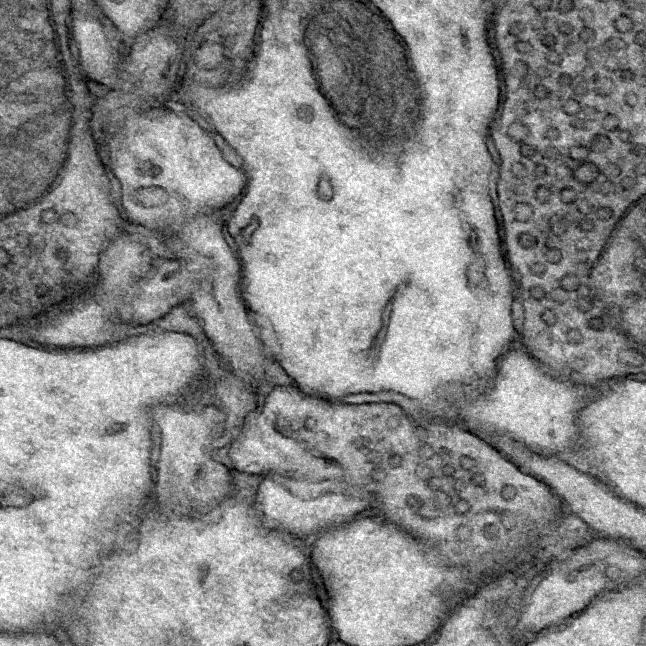

In [7]:
Image.fromarray(sample_image[5]).show()

In [8]:
import torch

In [9]:
inp = torch.tensor(sample_image)
inp = ((inp / 255) * 2 - 1).float()
print(inp.shape)
out = model(inp.unsqueeze(0).unsqueeze(0).to("cuda"))
affs, lsds = out

torch.Size([81, 646, 646])


In [10]:
affs = affs[0].detach().cpu().numpy()
lsds = lsds[0].detach().cpu().numpy()

In [11]:

lsds_2d = lsds[:,8,:,:]

In [12]:
import matplotlib.pyplot as plt

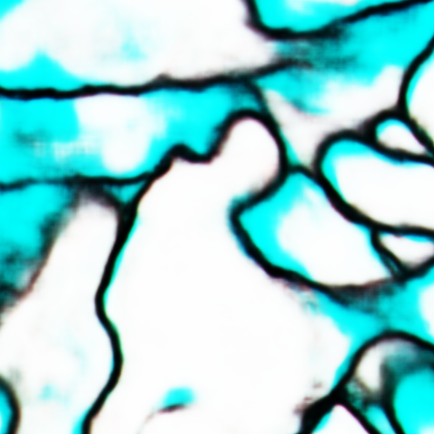

In [13]:
affs_2d = affs[:,8,:,:]
Image.fromarray((affs_2d.transpose(1, 2, 0) * 255).astype(np.uint8))

In [14]:
affs.shape

(3, 53, 434, 434)

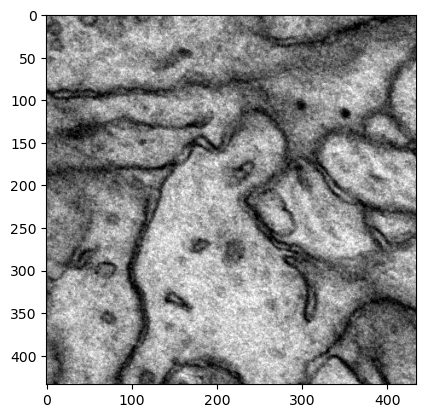

In [15]:
# cropped
cropped_shape = affs.shape[1:]
original_shape = sample_image.shape
difference = np.array(original_shape) - np.array(cropped_shape)
cropped_raw = sample_image[difference[0]//2:original_shape[0]-difference[0]//2, difference[1]//2:original_shape[1]-difference[1]//2, difference[2]//2:original_shape[2]-difference[2]//2]
cropped_raw = cropped_raw[8]
# horizontal flip
plt.imshow(cropped_raw, cmap="gray")

In [16]:
lsds.shape

(10, 53, 434, 434)

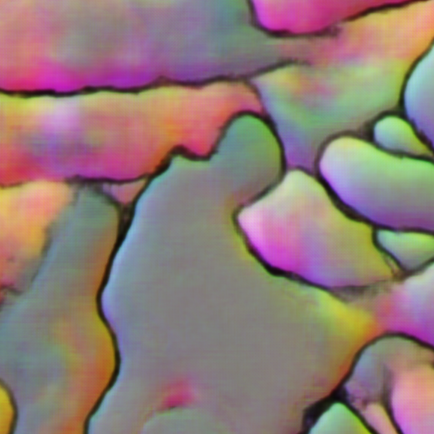

In [17]:
Image.fromarray((lsds_2d[:3,:,:].transpose(1, 2, 0) * 255).astype(np.uint8))

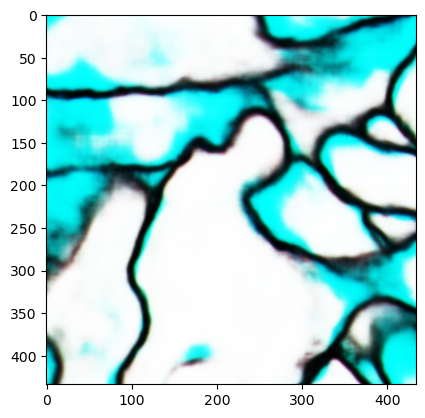

In [18]:
plt.imshow(affs_2d.transpose(1, 2, 0))

In [55]:
affs_2d[:,0,100]

array([0.94786125, 0.99498147, 0.9959311 ], dtype=float32)

In [19]:
from scipy.ndimage import (
    measurements,
    center_of_mass,
    maximum_filter,
    distance_transform_edt,
    binary_erosion
)
import mahotas
def watershed_from_boundary_distance(
    boundary_distances, boundary_mask, return_seeds=False, id_offset=0, min_seed_distance=10
):

    max_filtered = maximum_filter(boundary_distances, min_seed_distance)
    maxima = max_filtered == boundary_distances
    seeds, n = mahotas.label(maxima)

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds != 0] += id_offset

    fragments = mahotas.cwatershed(boundary_distances.max() - boundary_distances, seeds)

    if boundary_mask is not None:
        fragments *= boundary_mask

    ret = (fragments.astype(np.uint64), n + id_offset)
    if return_seeds:
        ret = ret + (seeds.astype(np.uint64),)

    return ret

def watershed_from_affinities(
    affs,
    max_affinity_value=1.0,
    fragments_in_xy=False,
    background_mask=False,
    mask_thresh=0.5,
    return_seeds=False,
    min_seed_distance=10,
):
    """Extract initial fragments from affinities using a watershed
    transform. Returns the fragments and the maximal ID in it.
    Returns:
        (fragments, max_id)
        or
        (fragments, max_id, seeds) if return_seeds == True"""

    if fragments_in_xy:

        mean_affs = 0.5 * (affs[-1] + affs[-2]) # affs are (c,z,y,x)
        depth = mean_affs.shape[0]

        fragments = np.zeros(mean_affs.shape, dtype=np.uint64)
        if return_seeds:
            seeds = np.zeros(mean_affs.shape, dtype=np.uint64)

        id_offset = 0
        for z in range(depth):

            boundary_mask = mean_affs[z] > mask_thresh * max_affinity_value
            boundary_distances = distance_transform_edt(boundary_mask)

            if background_mask is False:
                boundary_mask = None

            ret = watershed_from_boundary_distance(
                boundary_distances,
                boundary_mask,
                return_seeds=return_seeds,
                id_offset=id_offset,
                min_seed_distance=min_seed_distance,
            )

            fragments[z] = ret[0]
            if return_seeds:
                seeds[z] = ret[2]

            id_offset = ret[1]

        ret = (fragments, id_offset)
        if return_seeds:
            ret += (seeds,)

    else:

        boundary_mask = np.mean(affs, axis=0) > mask_thresh * max_affinity_value
        boundary_distances = distance_transform_edt(boundary_mask)

        if background_mask is False:
            boundary_mask = None

        ret = watershed_from_boundary_distance(
            boundary_distances, boundary_mask, return_seeds, min_seed_distance=min_seed_distance
        )

        fragments = ret[0]

    return ret

In [20]:
frags = watershed_from_affinities(affs, fragments_in_xy=True, return_seeds=False, min_seed_distance=10)

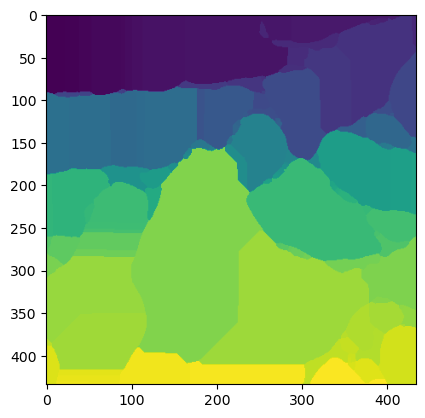

In [21]:
plt.imshow(frags[0][8])

In [22]:
z = 8
mean_affs = 0.5 * (affs[-1] + affs[-2]) # affs are (c,z,y,x)
mask_thresh = 0.5
max_affinity_value = 1
boundary_mask = mean_affs[z] > mask_thresh * max_affinity_value

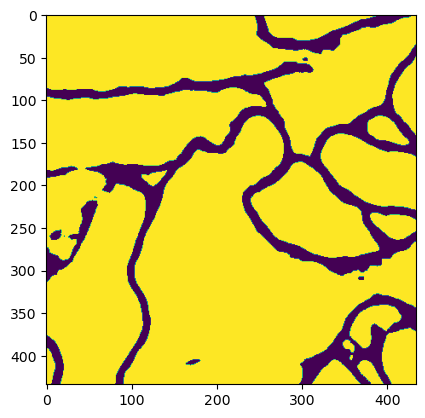

In [23]:
plt.imshow(boundary_mask)

In [24]:
boundary_distances = distance_transform_edt(boundary_mask)

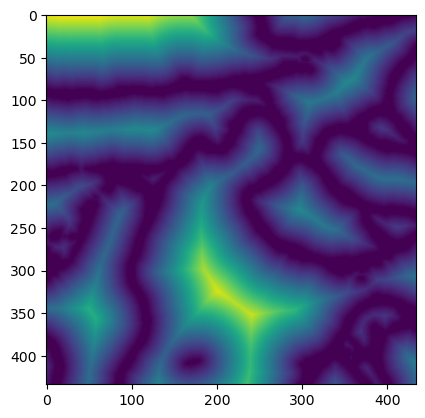

In [25]:
plt.imshow(boundary_distances)

In [26]:
import mahotas

In [27]:
Bc = np.ones((9, 9))
maxima = mahotas.morph.regmax(boundary_distances, Bc=Bc)
seeds,n_spots = mahotas.label(maxima, Bc=Bc)

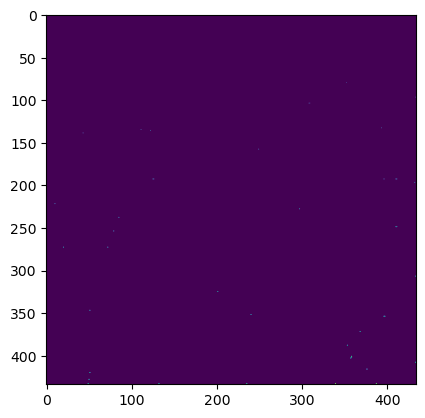

In [28]:
plt.imshow(seeds)

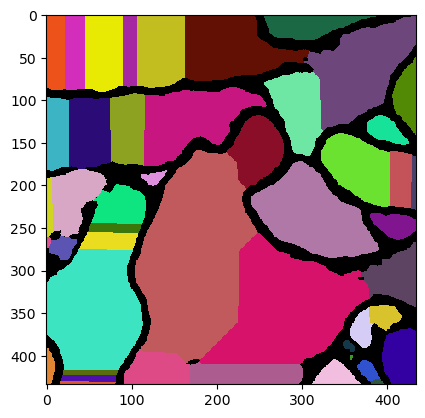

In [29]:
fragments = mahotas.cwatershed(boundary_distances.max() - boundary_distances, seeds)
fragments *= boundary_mask

plt.imshow(fragments, cmap=custom_cmap, interpolation="nearest")

In [30]:
max_filtered = maximum_filter(boundary_distances, 10)

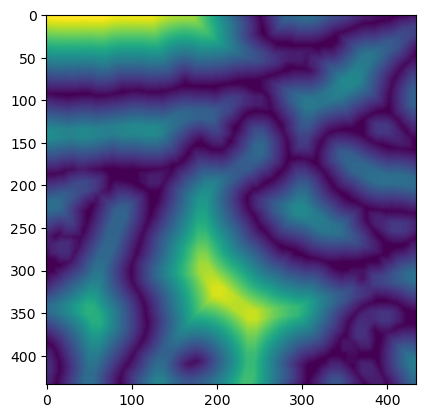

In [31]:
plt.imshow(max_filtered)

In [32]:

maxima = max_filtered == boundary_distances
seeds, n = mahotas.label(maxima)

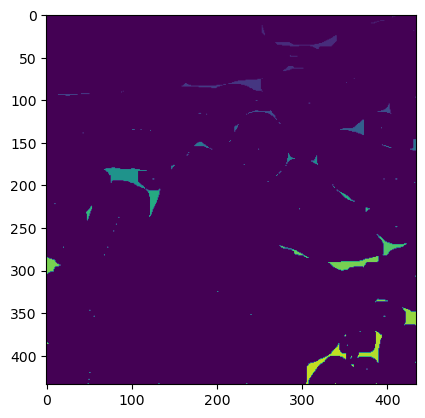

In [33]:
plt.imshow(seeds)

In [34]:
#fragments = mahotas.cwatershed(boundary_distances.max() - boundary_distances, seeds)

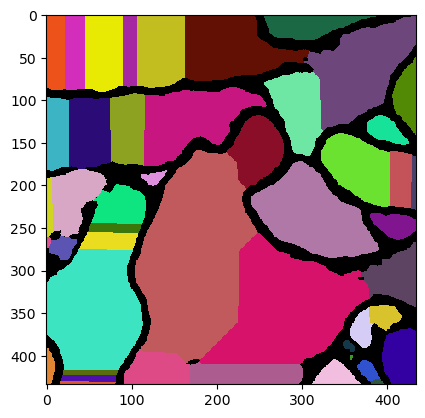

In [35]:
plt.imshow(fragments, cmap=custom_cmap, interpolation="nearest")

In [36]:
frags, num_objs, seeds = watershed_from_boundary_distance(
    boundary_distances,
    boundary_mask,
    return_seeds=True
)

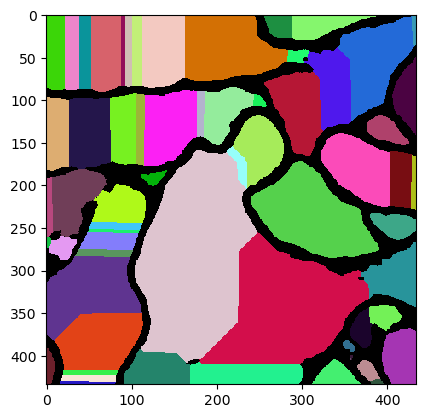

In [37]:
plt.imshow(frags, cmap=custom_cmap, interpolation="nearest")

In [38]:
#unsqueeze frags
frags = frags[np.newaxis]

In [39]:
frags.shape

(1, 434, 434)

In [40]:
from funlib.segment.arrays import relabel, replace_values
average_affs = np.mean(affs[-2:]/max_affinity_value, axis=0)
filtered_fragments = []

fragment_ids = np.unique(frags)

for fragment, mean in zip(
        fragment_ids,
        measurements.mean(
            average_affs,
            frags,
            fragment_ids)):
    if mean < 0.05:
        filtered_fragments.append(fragment)

filtered_fragments = np.array(
    filtered_fragments,
    dtype=frags.dtype)
replace = np.zeros_like(filtered_fragments)
replace_values(frags, filtered_fragments, replace, inplace=True)

/tmp/ipykernel_871838/2265753595.py:9: DeprecationWarning: Please import `mean` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  measurements.mean(


array([[[  1,   1,   1, ...,   0,   0,  18],
        [  1,   1,   1, ...,  18,  18,  18],
        [  1,   1,   1, ...,  18,  18,  18],
        ...,
        [142, 142, 142, ..., 140, 140, 140],
        [142, 142, 142, ..., 140, 140, 140],
        [142, 142, 142, ..., 140, 140, 140]]], dtype=uint64)

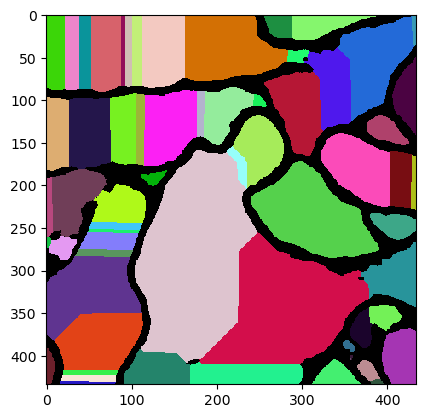

In [41]:
plt.imshow(frags[0], cmap=custom_cmap, interpolation="nearest")

In [42]:
frags.shape

(1, 434, 434)

In [43]:
affs[:,8,:,:][:,np.newaxis,:,:].shape

(3, 1, 434, 434)

In [44]:
import waterz
final_frags = np.copy(frags)
generator = waterz.agglomerate(
        affs=affs[:,8,:,:][:,np.newaxis,:,:],
        thresholds=[0.02],
        fragments=frags,
        scoring_function='OneMinus<HistogramQuantileAffinity<RegionGraphType, 25, ScoreValue, 256, false>>',
        discretize_queue=256,
        return_merge_history=False,
        return_region_graph=False)

final_frags[:] = next(generator)

for _ in generator:
    pass

Re-using already compiled waterz version
Creating memory-contiguous affinity arrray (avoid this by passing C_CONTIGUOUS arrays)
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 151 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 49
merging until threshold 0.02
computing initial scores
merging until 0.02
min edge score 0.00585938
threshold exceeded
merged 20 edges
extracting segmentation


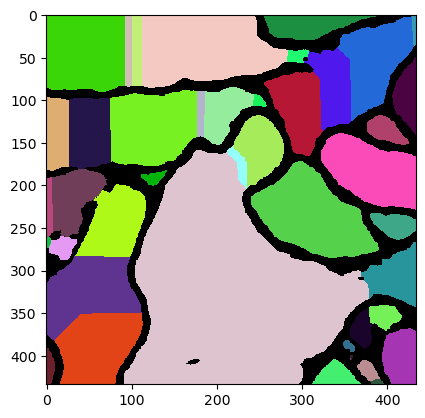

In [45]:
plt.imshow(final_frags[0], cmap=custom_cmap, interpolation="nearest")

In [49]:
seg = np.copy(final_frags)
generator = waterz.agglomerate(
        affs=affs[:,8,:,:][:,np.newaxis,:,:],
        thresholds=[0, 0.5],
        fragments=final_frags,
        scoring_function='OneMinus<MeanAffinity<RegionGraphType, ScoreValue>>',
        discretize_queue=256,
        return_merge_history=False,
        return_region_graph=False)

seg[:] = next(generator)

for _ in generator:
    pass


Re-using already compiled waterz version
Creating memory-contiguous affinity arrray (avoid this by passing C_CONTIGUOUS arrays)
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 150 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 7
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.418445
threshold exceeded
merged 0 edges
merging until threshold 0.5
merging until 0.5
min edge score 0.418445
merged 6 edges
extracting segmentation


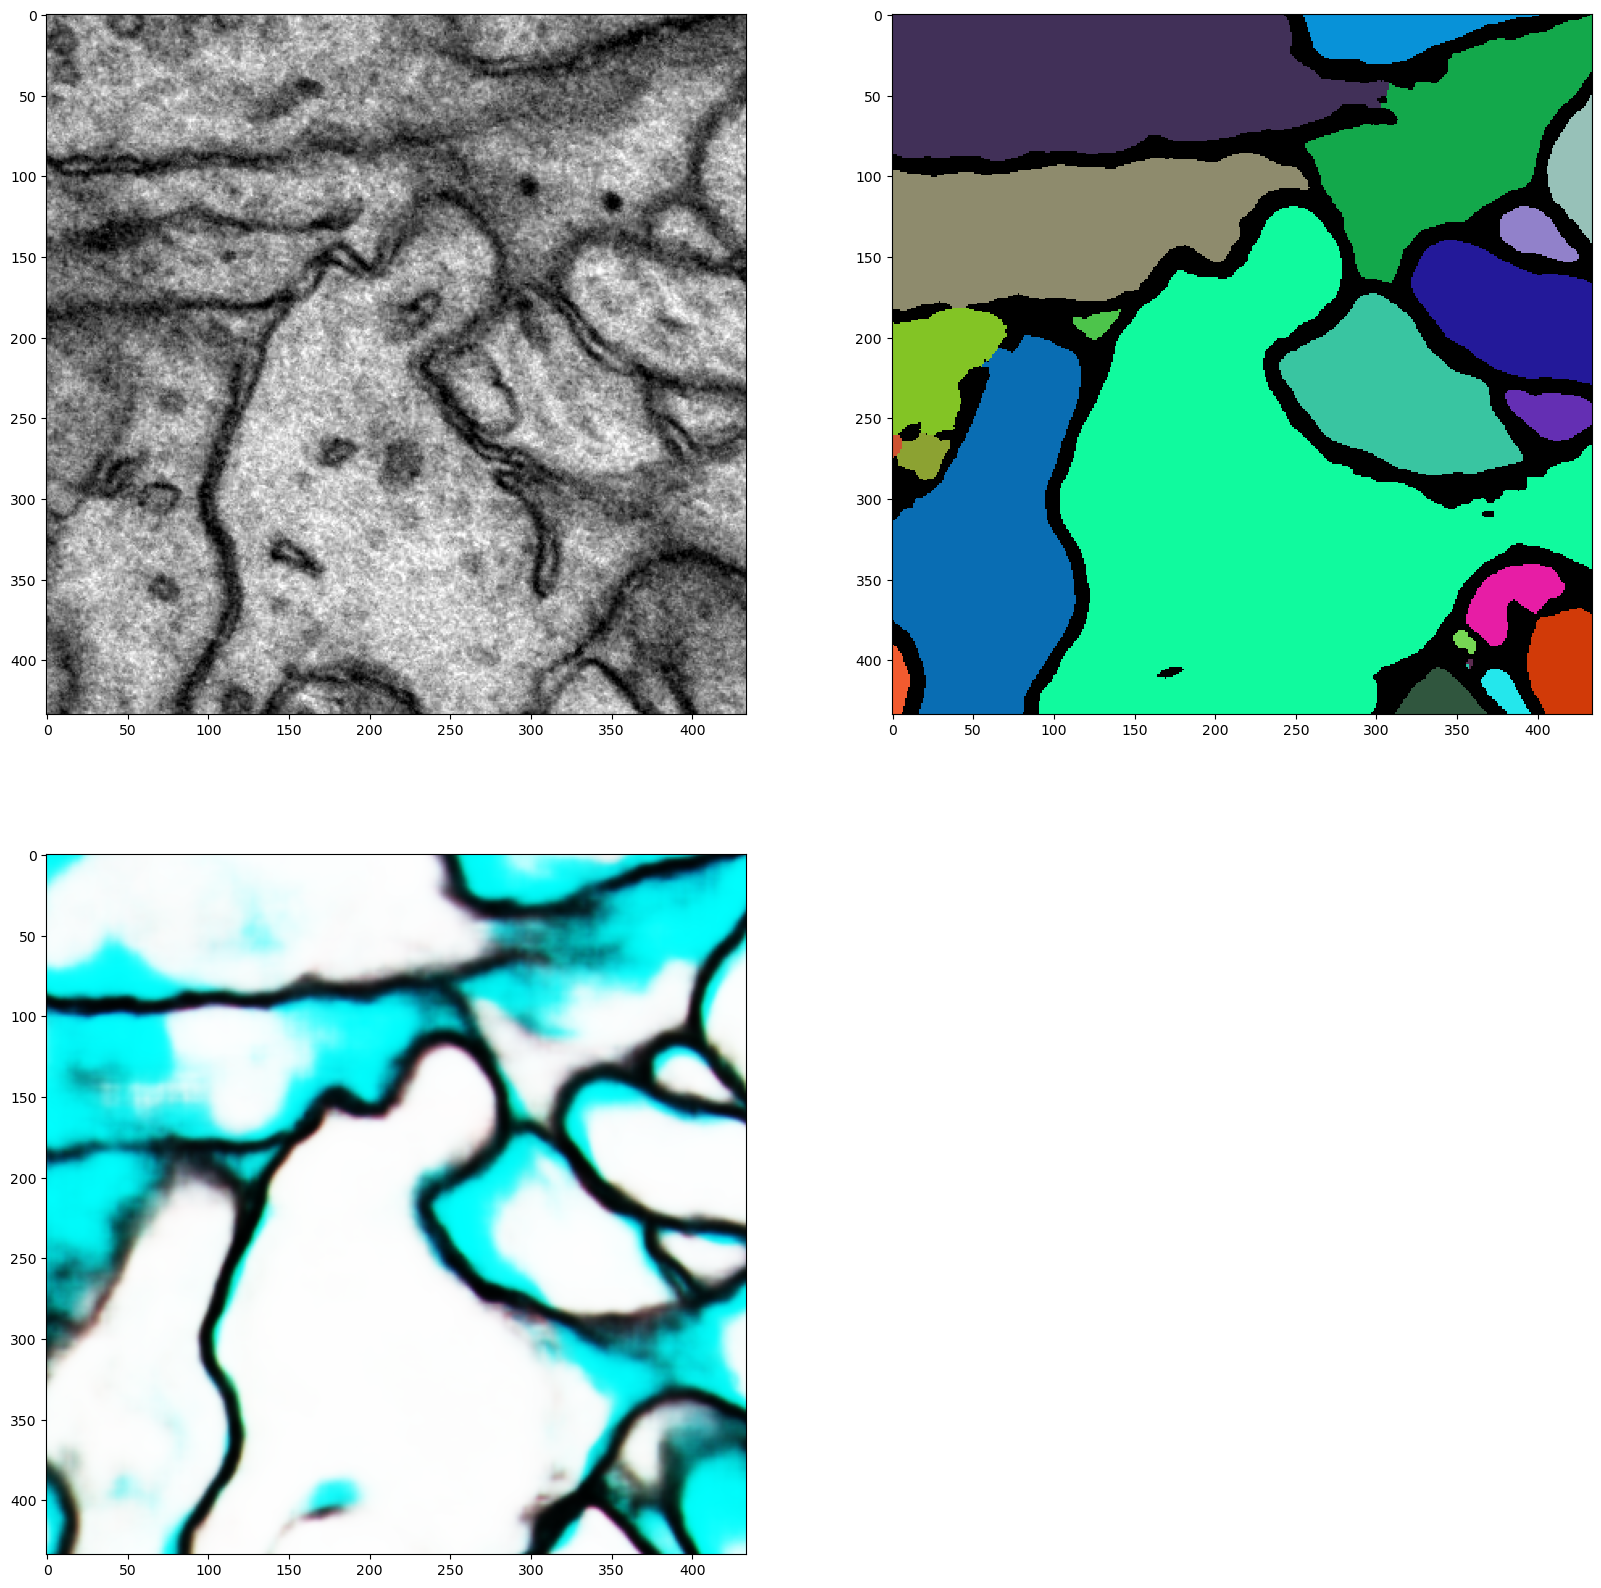

In [50]:
# display raw and segmentation
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(cropped_raw, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(seg[0], cmap=custom_cmap, interpolation="nearest")
plt.subplot(2, 2, 3)
plt.imshow(affs_2d.transpose(1, 2, 0))

In [48]:
seg_counts = np.unique(seg, return_counts=True)